In [1]:
import numpy as np
import os

import torch
from torchvision import datasets, transforms
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Parameters
img_size = 128
capacity = 64
latent_dims = 32
learning_rate = 0.001
n_epochs = 10
variational_beta = 1
batch_size = 32
device = "mps"

In [3]:
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

In [4]:
root_dir = "celeba_gan/"
names = load_image_names("./" + root_dir + "list_eval_partition.txt")

In [5]:
# Stack image names with the corresponding partition offset
train_files, valid_files, test_files = [], [], []

for name in names:
    if name[-1] == "0":
        train_files.append(name[:-2])
    elif name[-1] == "1":
        valid_files.append(name[:-2])
    elif name[-1] == "2":
        test_files.append(name[:-2])

In [6]:
# Build a custom dataset
class CustomDataset(datasets.ImageFolder):
    def __init__(self, root, file_list, transform=None):
        super().__init__(root, transform)
        self.file_list = set(file_list)
        self.samples = [s for s in self.samples if os.path.basename(s[0]) in self.file_list]
        self.targets = [s[1] for s in self.samples]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [7]:
transform_train = transforms.Compose([transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.Resize(img_size),
                                      transforms.CenterCrop(img_size),
                                      transforms.ToTensor()])

transform_non_train = transforms.Compose([transforms.Resize(img_size),
                                          transforms.CenterCrop(img_size),
                                          transforms.ToTensor()])

In [8]:
dataset_train = CustomDataset(root=root_dir, file_list=train_files, transform=transform_train)
dataset_valid = CustomDataset(root=root_dir, file_list=valid_files, transform=transform_non_train)
dataset_test = CustomDataset(root=root_dir, file_list=test_files, transform=transform_non_train)

In [9]:
"""
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
"""

def randomlyLoadNImages(dataset, N_INSTANCES):
    
    # Create dataloader using a subset of the dataset
    indices = np.random.permutation(N_INSTANCES)
    sampler = SubsetRandomSampler(indices)
    return torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

dataloader_train = randomlyLoadNImages(dataset_train, 10000)
dataloader_valid = randomlyLoadNImages(dataset_valid, 1250)
dataloader_test = randomlyLoadNImages(dataset_test, 1250)

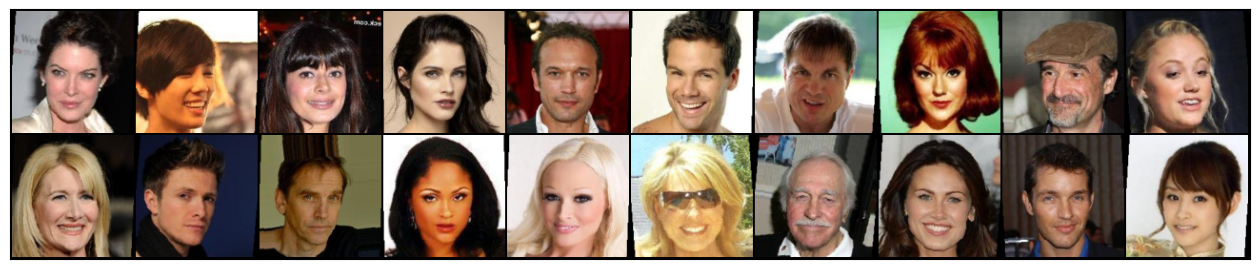

In [10]:
images, _ = next(iter(dataloader_train))
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:20], 10).permute(1, 2, 0));

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=capacity, out_channels=capacity*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.fc_mu = nn.Linear(in_features=int(capacity*2*img_size*img_size/16), out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=int(capacity*2*img_size*img_size/16), out_features=latent_dims)
            
    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=int(capacity*2*img_size*img_size/16))
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=capacity*2, out_channels=capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=capacity, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, int(img_size/4), int(img_size/4))
        x = self.main(x)
        return x

In [13]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [14]:
def vae_loss(recon_x, x, mu, logvar):
    
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, img_size*img_size), x.view(-1, img_size*img_size), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence

In [15]:
vae = VariationalAutoEncoder()
vae = vae.to(device)

n_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % n_params)

Number of parameters: 12982595


In [16]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
valid_loss_min = np.Inf 

train_loss_list = []
valid_loss_list = []
for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the VAE model
    vae.train()
    for batch_idx, (batch, _) in enumerate(dataloader_train):
        batch = batch.to(device)

        # vae reconstruction
        batch_recon, latent_mu, latent_logvar = vae(batch)
        
        # reconstruction error
        loss = vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # gradient step
        optimizer.step()
        
        train_loss += (loss.data - train_loss)/(batch_idx + 1)
        
    # Validate the VAE model
    vae.eval()
    for batch_idx, (batch, _) in enumerate(dataloader_valid):
        batch = batch.to(device)

        # vae reconstruction
        batch_recon, latent_mu, latent_logvar = vae(batch)
        
        # reconstruction error
        loss = vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        valid_loss += (loss.data - valid_loss)/(batch_idx + 1)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # print training/validation statistics
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
        epoch, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
            valid_loss_min,
            valid_loss))
        torch.save(vae.state_dict(), "vae.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 883927.437500 	Validation Loss: 823352.937500
Validation loss decreased (inf --> 823352.937500).  Saving model ...
Epoch: 2 	Training Loss: 821449.750000 	Validation Loss: 812140.687500
Validation loss decreased (823352.937500 --> 812140.687500).  Saving model ...
Epoch: 3 	Training Loss: 816072.875000 	Validation Loss: 807029.500000
Validation loss decreased (812140.687500 --> 807029.500000).  Saving model ...
Epoch: 4 	Training Loss: 814412.250000 	Validation Loss: 806081.312500
Validation loss decreased (807029.500000 --> 806081.312500).  Saving model ...
Epoch: 5 	Training Loss: 813854.375000 	Validation Loss: 805283.312500
Validation loss decreased (806081.312500 --> 805283.312500).  Saving model ...
Epoch: 6 	Training Loss: 812822.062500 	Validation Loss: 804104.312500
Validation loss decreased (805283.312500 --> 804104.312500).  Saving model ...
Epoch: 7 	Training Loss: 811889.937500 	Validation Loss: 804140.625000
Epoch: 8 	Training Loss: 811200.125000 

In [17]:
# Converting loss tensors to lists
for i in range(len(train_loss_list)):
    train_loss_list[i] = train_loss_list[i].to('cpu').numpy().tolist()
    valid_loss_list[i] = valid_loss_list[i].to('cpu').numpy().tolist()

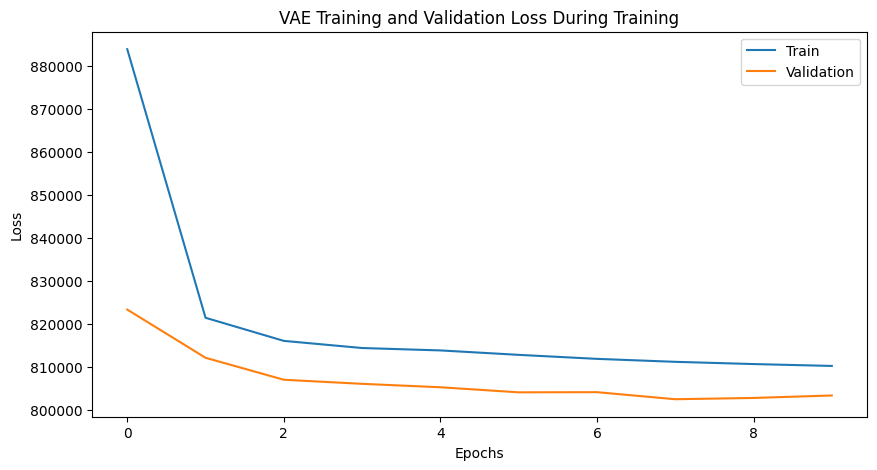

In [18]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("VAE Training and Validation Loss During Training")
plt.plot(train_loss_list, label="Train")
plt.plot(valid_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
images, _ = next(iter(dataloader_train))

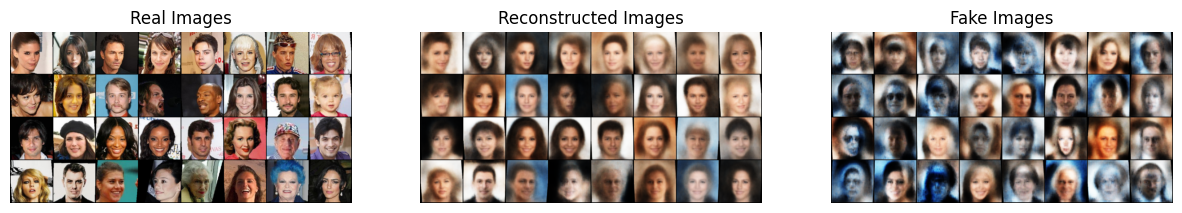

In [20]:
# Disable gradient calculation
torch.set_grad_enabled(False)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Real Images
axs[0].axis("off")
axs[0].set_title("Real Images")
real_images = make_grid(images.to(device)[:32], padding=2, normalize=True).cpu()
axs[0].imshow(np.transpose(real_images, (1, 2, 0)))

torch.set_grad_enabled(False)  # Manually disable gradient computation

images = images.to(device)
images, _, _ = vae(images)
images = images.cpu()

# Reconstructed Images
axs[1].axis("off")
axs[1].set_title("Reconstructed Images")
reconstructed_images = images
reconstructed_images_grid = make_grid(reconstructed_images[:32], padding=2, normalize=True)
axs[1].imshow(np.transpose(reconstructed_images_grid, (1, 2, 0)))

# Generate Fake Images
torch.set_grad_enabled(False)  # Manually disable gradient computation

latent = torch.randn(128, latent_dims, device=device)
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

axs[2].axis("off")
axs[2].set_title("Fake Images")
fake_images_grid = make_grid(img_recon.data[:32], padding=2, normalize=True)
axs[2].imshow(np.transpose(fake_images_grid.numpy(), (1, 2, 0)));

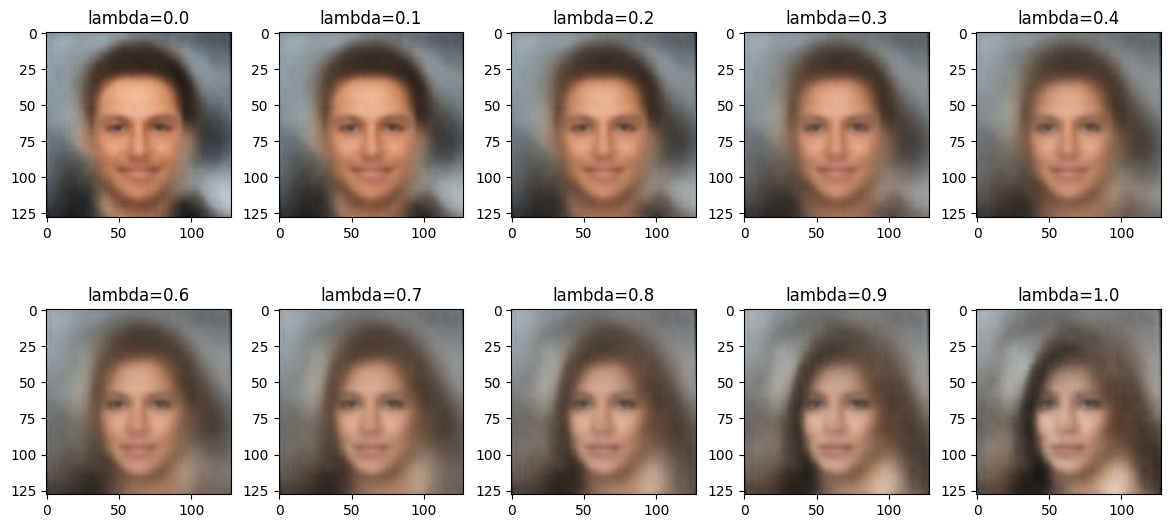

In [21]:
vae.eval()

def interpolation(model, img1, img2, lambda_):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda_* latent_1 + (1- lambda_) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

images, _ = next(iter(dataloader_test))
lambda_range = np.linspace(0, 1, 10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for index, lambda_ in enumerate(lambda_range):
    inter_image = interpolation(vae, images[0].unsqueeze(0), images[1].unsqueeze(0), lambda_)
   
    #inter_image = to_image(inter_image)
    inter_image = inter_image.clamp(0, 1)
    inter_image = torch.moveaxis(inter_image.squeeze(0), 0, 2)
    
    image = inter_image.numpy()
   
    axs[index].imshow(image)
    axs[index].set_title('lambda='+str(round(lambda_,1)))
plt.show()

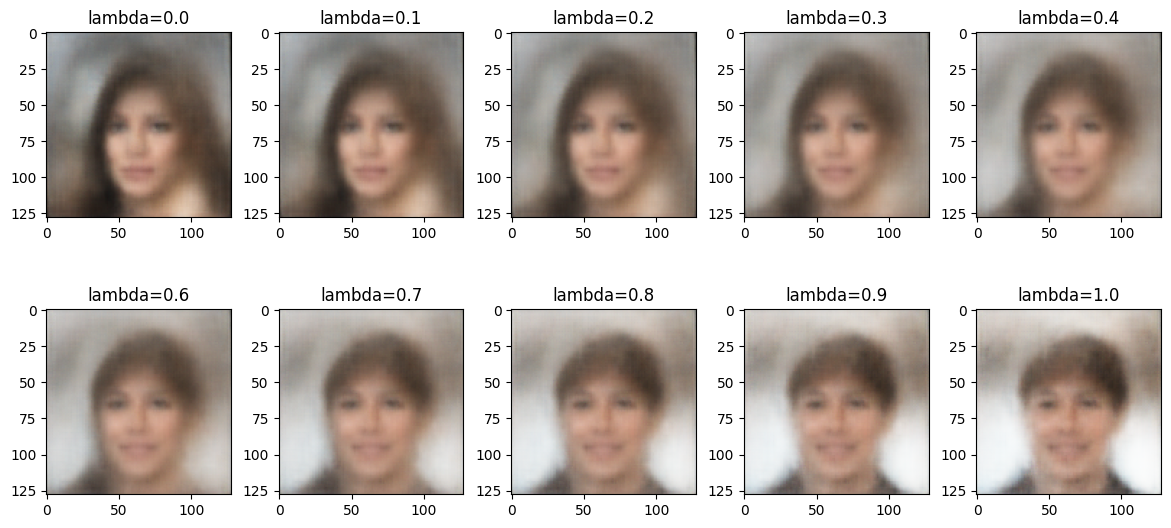

In [22]:
vae.eval()

def interpolation(model, img1, img2, lambda_):
    with torch.no_grad():
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda_* latent_1 + (1- lambda_) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

images, _ = next(iter(dataloader_test))
lambda_range = np.linspace(0, 1, 10)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for index, lambda_ in enumerate(lambda_range):
    inter_image = interpolation(vae, images[0].unsqueeze(0), images[1].unsqueeze(0), lambda_)
   
    inter_image = inter_image.clamp(0, 1)
    inter_image = torch.moveaxis(inter_image.squeeze(0), 0, 2)
    
    image = inter_image.numpy()
   
    axs[index].imshow(image)
    axs[index].set_title('lambda='+str(round(lambda_,1)))
plt.show()